# 1. **Dataset**

For the dataset we use MNIST (Modified National Institute of Standards and Technology) which is a large database of handwritten digits that is commonly used for training various image processing systems.

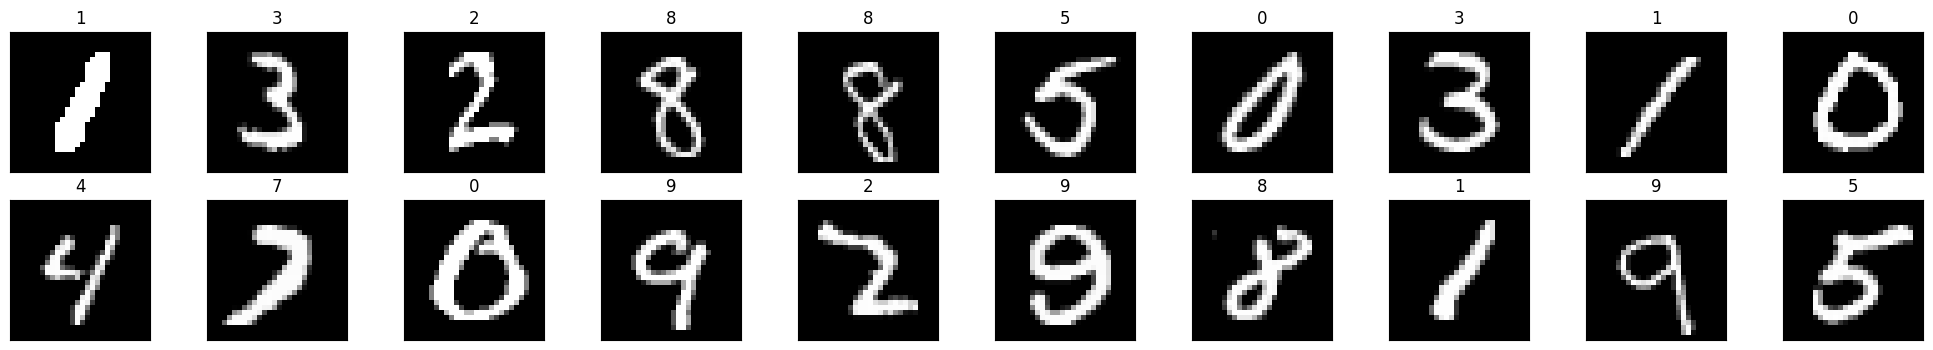

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# List of transformations to apply to the input
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Shuffle because static training data that is unchaged over training iterations
# runs the risk of getting stuck in a local minumum whereas you'd want to training
# to converge to a global minimum
training_dataloader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

# The validation dataloader has no reason to be shuffled as its outcome does not impact the model
validation_dataloader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

def tensor2image(tensor):
    image = tensor.clone().detach().numpy()
    # Reorder the channels from 1x28x28 to 28x28x1
    image = image.transpose(1, 2, 0)
    # Denormalize the image
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

iterable = iter(training_dataloader)

# Gets the first batch of 100 (batch_size) images
images, labels = next(iterable)

fig = plt.figure(figsize=(25, 4))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.set_title(labels[idx].item())
    im = tensor2image(images[idx])
    plt.imshow(im)

# 2. **Creating a model**


In [ ]:
from torch import nn
import torch.nn.functional as F


class DigitClassifier(nn.Module):

    def __init__(self, inputs, hidden1, hidden2, outputs):
        super().__init__()

        self.linear1 = nn.Linear(inputs, hidden1)
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.linear3 = nn.Linear(hidden2, outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)

        x = self.linear2(x)
        x = F.relu(x)

        x = self.linear3(x)

        return x

model = DigitClassifier(784, 125, 65, 10)

# 3. **Training and validating the model**

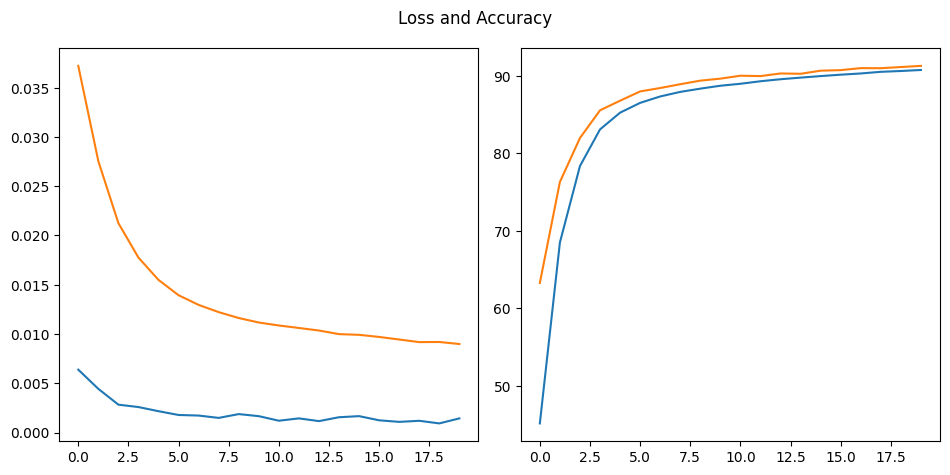

In [ ]:
model = DigitClassifier(784, 125, 65, 10)

# Loss function used for multiclass classification
lossfn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

epochs = 20
losses, vlosses = [], []
accuracy, vaccuracy = [], []

for e in range(epochs):

    loss, vloss = 0.0, 0.0
    correct, vcorrect = 0.0, 0.0

    for inputs, labels in training_dataloader:
        # Flatten inputs from 1x28x28 to 1x784 to match the model inputs
        inputs = inputs.view(inputs.shape[0], -1)
        # Pass the inputs to the model
        outputs = model(inputs)

        # Calculate the prediction accuracy through the loss function
        loss = lossfn(outputs, labels)

        # Zero out gradients before backpropagation
        optimizer.zero_grad()
        # Backpropagate
        loss.backward()
        optimizer.step()

        # Get the index of the labels with the max prediction score
        # eg. if labels [3, 4, 5] had scores of [2, 1, 0.2] the function
        # would return index 0 because 2 is the highest score an found at index 0
        _, preds = torch.max(outputs, 1)

        loss += loss.item()
        # Because the labels and the indices are both [0, 1, 2 ...] we can easily
        # filter the correct predictions [0, 1, 2] == [1, 1, 2] => [0, 1, 1] => 2 correct
        correct += torch.sum(labels.data == preds)

    else:

        with torch.no_grad():

            for vinputs, vlabels in validation_dataloader:
                vinputs = vinputs.view(vinputs.shape[0], -1)
                voutputs = model(vinputs)
                vloss = lossfn(voutputs, vlabels)
                _, vpreds = torch.max(voutputs, 1)
                vloss += vloss.item()
                vcorrect += torch.sum(vlabels.data == vpreds)

            avgloss = loss / len(training_dataloader)
            avgacc = correct / len(training_dataloader)
            losses.append(avgloss)
            accuracy.append(avgacc)

            # print('loss : {:.4f} -  acc : {:.4f}'.format(avgloss, avgacc.item()))

            avgloss = vloss / len(validation_dataloader)
            avgacc = vcorrect / len(validation_dataloader)
            vlosses.append(avgloss)
            vaccuracy.append(avgacc)

            # print('vloss : {:.4f} -  vacc : {:.4f}'.format(avgloss, avgacc.item()))

fig, axes = plt.subplot_mosaic("AB", tight_layout=True, figsize=(9.6, 4.8))
fig.suptitle('Loss and Accuracy')

axes['A'].plot(range(epochs), losses, label='training loss')
axes['A'].plot(range(epochs), vlosses, label='validation loss')
axes['B'].plot(range(epochs), accuracy, label='training accuracy')
axes['B'].plot(range(epochs), vaccuracy, label='validation accuracy')


# 4. Testing the model

The number is 5


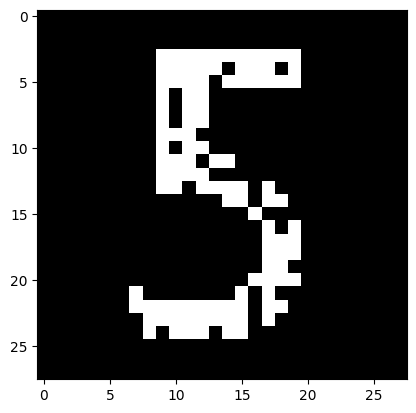

In [24]:
import base64
from PIL import Image, ImageOps

imgdata = b'/9j/4AAQSkZJRgABAQAASABIAAD/4QCMRXhpZgAATU0AKgAAAAgABQESAAMAAAABAAEAAAEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAIdpAAQAAAABAAAAWgAAAAAAAABIAAAAAQAAAEgAAAABAAOgAQADAAAAAQABAACgAgAEAAAAAQAAAICgAwAEAAAAAQAAAIAAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/AABEIAIAAgAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/3QAEAAj/2gAMAwEAAhEDEQA/APf6KKKACiiigAoorF1rxd4f8OTxQaxq1tZSyrvRZmwWGcZFAG1RXJf8LQ8Ef9DNp3/f2j/hZ/gj/oZtO/7+0AdbRXJD4neCT08S2B+j5/pTv+Fl+De3iC0P0JP9KAOrorlR8SfB5OBrtv8A98t/hXQ6fqFpqthDfWM6T2sy7o5U6MPUUAWaKKKACiiigD//0Pf6KKKACiiigAr53+PMrf8ACa2ChiNmnjofWRv8K+iK+cPju+fiBAn93Toj+ckv+FAHncUjZ+8fzq2rNjO41Utk3vXpHhj4W6j4m0OLVLa/tIIpHdAsqMW+VipPHuKAOGDN6mpFLHua9RX4H6sPvazYfhA//wAVUi/BLVB/zGbH/vw//wAVQB5gmc9TX0X8MJC/gDT8n7rSr+UjVw6/BXUh11my/wDAd/8A4qvS/CWgv4b8O2+mSTrO8bOxdFKg7mLcAk+tAG5RRRQAUUUUAf/R9/ooooAKKKKACvm346c/ENPbToP/AEOWvpKvmv45HPxEPtYQf+hS0AcLYDL19PfC+Lyvh9pv+2ZX/ORjXzDYH94K+ovhrj/hX2k4/uPn672oA6yiiigAooooAKKKKACiiigD/9L3+iiigAooooAK+afjcd3xGlHpZW4/WSvpavmb40MrfE65QuoY2luFBYAn73T160AcHBIY5ARXoHh/4m+ItCsLextJLJ7KHO2Ka3LNyST8wYdz6Vw6abeY3CxvSv8AeFrIR+e3FSRFRIYt6+avWPPzD6jrQB7fpHxsjkZU1fSGiycGW0k8wAepVsH8BmvRtF8RaT4htzNpd7HcBfvqOHT2ZTyPxr5VQ+lXrDULrT7yO7s7iS3uI/uSxnDD29x7Hg0AfWFFcR4C8ex+J4fsV7si1WJNzBeFmUdWUdvcdvpXb0AFFFFABRRRQB//0/f6KKKACiiigAqv9gs/tT3X2WH7Q4AaXyxvIHTJ61YooAKztT0DSNagMGp6baXcZ6iaJW/nWjRQB454u+DQjhlvfC0j71BY6fM+4P7RueQfZiR2yvWvJIpD5jRyKySxsUdHGGVgcEEdiCMYr6+rwn42+H4tO1vT9ftkVBfk29yBxukVcq31KhgT/srQBxOnX9xpt/Be2knl3EDh429CPX2PIPsTX01oGsQ69oVpqcI2rOmWTP3G6Mp+hBFfLSHgV7V8Gb5pdH1GxZsiCdZEHoHXn/x5SfxoA9NooooAKKKKAP/U9/ooooAKKKRmCqWYgADJJ7UALRSAggEHINLQAUUUUAFeV/HeWMeFdLhIzJJqK7PbEbkn8uPxr1J3WNGd2CqoyWJwAK+bviP4sj8YeKYzZvv0qwUx27jpK5+/IPbgAH0yehFAHNR9BXrfwVRvtOsyc7fLhX8cua8mQdK93+EeltZeFHvXBDX0xkXP9xRtX88E/jQB39FFFABRRRQB/9X3+iiigAqnq43aNfD1t5B/46auVFcRedbSxf30K/mMUAfK/g/4o+IvCdrb20U63tgsaAWt2SQowOEcfMv05HoBXq2l/HrQLlANS0+/spMclFE6Z9tvzfmBXgGp6RqGhXK2WqWktncIAmyZSu7HGVJ4Ye4z1FVRuU4II+tAH1Mnxg8FPEX/ALTmGP4TZzA/ltrM1D44eG7eM/2fa6jfydgIPJX8TJj9Aa+dYmPTNXIqAOz8U/ELXvF6NbXDJZac33rO2YkP/vuQCw9sAeoNc4igDio41J6Vv+HfDGqeJbsQ6bbF0BxJcNxFH65b19hk/wA6AH+F/D1x4l1uDToAwRvmmlA/1UY6t9ew9yPevpe1tobK0htbdBHDCgREHQKBgCsbwn4UsvCmmfZrf97PJhp7hhgyN/QDsP65Nb9ABRRRQAUUUUAf/9b3+iiigAooooAgu7K1v7doLy2huIWGGjmQOp/A1xeo/B7wVqBLLpRs2PU2UzRD/vkHb+ld3RQB5HL8AdGLE2+uanGOwZYnx/44DSRfAWxQ/P4j1Bh6LBCP5qa9dooA4XTPhJ4WsGV54J79wMH7VLlT9UGFP5V20FvDawJDbxJFEgwqRqFUD2AqSigAooooAKKKKACiiigD/9k='

with open("5.png", "wb") as f:
    f.write(base64.decodebytes(imgdata))

img = Image.open('5.png')
img = ImageOps.invert(img)
img = img.convert('1') # black/white
tensor = transform(img)
plt.imshow(tensor2image(tensor))

tensor = tensor.view(tensor.shape[0], -1)
output = model(tensor)
_, preds = torch.max(output, 1)
print('The number is {0}'.format(preds.item()))